This notebook demonstrates how to use the classes in `haloanalysis.model` to perform likelihood scans of the IGMF parameter space.  To start with we construct the following:

* SED objects for the primary spectrum -- this potentially includes SEDs for both the TeV and GeV regimes
* SED for the cascade spectrum
* A cascade model object -- this is used to generated
* A spectrum object for the primary spectrum parameterization

These objects are then used to instantiate a `CascLike` object which is responsible for computing the total model likelihood from the sum of the primary and cascade likelihood functions.

In [11]:
%matplotlib inline
from astropy.table import Table
import matplotlib.pyplot as plt
import matplotlib.cm
from fermipy.spectrum import PLExpCutoff
from fermipy.castro import CastroData
from haloanalysis.model import make_prim_model, make_casc_model
from haloanalysis.model import CascModel, CascLike
from haloanalysis.utils import Axis
from haloanalysis.sed import HaloSED
import numpy as np

fn = PLExpCutoff([1E-11,-1.5,1E6],scale=1E3)

tab_casc = Table.read('1es0229_casc_sed.fits')
sed_prim = CastroData.create_from_flux_points('veritas_1es0229.ecsv')
sed_casc = HaloSED.create_from_fits(tab_casc[0])
hmm = CascModel.create_from_fits('results.fits')
hl = CascLike(hmm, fn, sed_casc, sed_prim)

Once the cascade likelihood object is instantiated we can build a 2D grid in Lcoh and B for the likelihood scan.  We fill an array with the cascade likelihood values by calling `CascLike.fit` at each point.  This method fits for the best-fit parmeters of the primary spectrum given the cascade model.

In [12]:
nstep = 11
lcoh_scan = np.linspace(-4,4,nstep)
igmf_scan = np.linspace(-20,-12,nstep)    
bpars = np.meshgrid(lcoh_scan, igmf_scan)

model_lnl = np.zeros(bpars[0].shape)*np.nan
p1 = fn.params

for idx, x in np.ndenumerate(bpars[0]):

    p0 = [bpars[0][idx], bpars[1][idx]]
    lnl, p1 = hl.fit(p0,p1,method='SLSQP')
    model_lnl[idx] = lnl


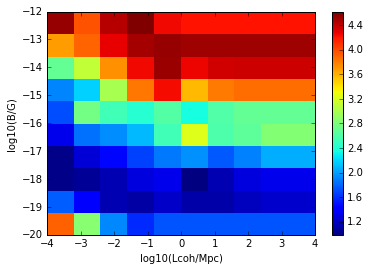

In [13]:
plt.figure()
plt.pcolormesh(bpars[0],bpars[1],model_lnl)
plt.gca().set_xlabel('log10(Lcoh/Mpc)')
plt.gca().set_ylabel('log10(B/G)')
plt.colorbar()